# distilBERT. Дообучение

In [ ]:
# Монтирование google-диска
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# Проверка доступной видеокарты
!nvidia-smi

Mon Jun  5 19:21:05 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8    13W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Установка и импорт библиотек

In [ ]:
!pip install transformers datasets evaluate accelerate

In [ ]:
# Импорт библиотек
from datasets import load_dataset
from transformers import DistilBertTokenizerFast
from transformers import DistilBertForSequenceClassification
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import evaluate
import torch

%matplotlib inline
sns.set(style='whitegrid')

In [ ]:
# Проверка доступности GPU
torch.cuda.is_available()

True

## Подготовка датасета

Прежде чем пользоваться самой моделью нам необходимо загрузить датасет, токенизировать его и разбить на обучающую и тестовую выбокри. 

In [ ]:
# Загрузка датасета
dataset = load_dataset("csv", data_files="issue_data_encoded_small.csv", data_dir="drive/MyDrive/datasets")

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
# Добавление токенизатора
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-cased")

In [ ]:
# Функция токенизации
def tokenize_function(data):
    return tokenizer(data["text"], padding="max_length", truncation=True, max_length=384, return_tensors='pt')

In [ ]:
# Токенизация текста
dataset = dataset.map(tokenize_function, batched=True)

In [ ]:
# Разделение выборки на обучающую и тестовую
dataset = dataset['train'].train_test_split(test_size=0.2)

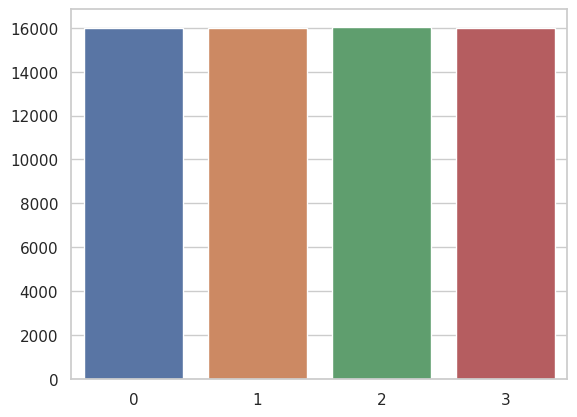

In [ ]:
# Распределение меток в обучающей выборке
train_labels, train_count = np.unique(dataset['train']['labels'], return_counts=True)
sns.barplot(x=train_labels, y=train_count)
plt.show()

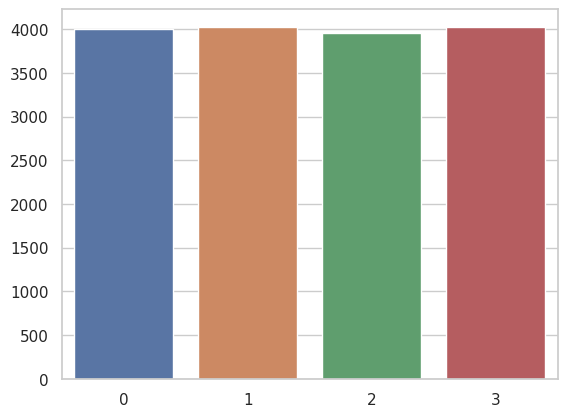

In [ ]:
# Распределение меток в тестовой выборке
test_labels, test_count = np.unique(dataset['test']['labels'], return_counts=True)
sns.barplot(x=test_labels, y=test_count)
plt.show()

In [ ]:
# Структура датасета
dataset

DatasetDict({
    train: Dataset({
        features: ['labels', 'text', 'input_ids', 'attention_mask'],
        num_rows: 64000
    })
    test: Dataset({
        features: ['labels', 'text', 'input_ids', 'attention_mask'],
        num_rows: 16000
    })
})

## Обучение модели

In [ ]:
id2label = {0 : 'bug', 1 : 'enhancement', 2 : 'documentation', 3 : 'question'}
#label2id = {'bug' : 0, 'feature' : 1, 'documentation' : 2, 'question' : 3}

In [ ]:
# Загрузка модели
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-cased", num_labels=4,
                                                         id2label=id2label)

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'pre_classifier

In [ ]:
# Настройка контролируемых гиперпараметров
training_args = TrainingArguments(output_dir="drive/MyDrive/models/distilBERT/distilBERT_model_data",
                                  logging_dir="drive/MyDrive/models/distilBERT/distilBERT_model_data/log",
                                  evaluation_strategy="epoch",
                                  save_strategy="epoch",
                                  per_device_train_batch_size=16,
                                  per_device_eval_batch_size=16,
                                  learning_rate=1e-5,
                                  num_train_epochs=4,
                                  fp16=True,
                                  optim="adamw_torch_fused",
                                  remove_unused_columns = True,
                                  load_best_model_at_end=True,
                                  metric_for_best_model="f1")

In [ ]:
# Загрузка DataCollator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
# Загрузка метрик для валидации
metric_f = evaluate.load("f1")

In [ ]:
# Функция для подсчёта метрик
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    f = metric_f.compute(predictions=predictions, references=labels, average='micro')
    return f

In [ ]:
# Описание тренера
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    compute_metrics=compute_metrics,
    data_collator=data_collator
)

In [ ]:
# Дообучение модели
trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,0.655000,0.612169,0.783375
2,0.561500,0.600557,0.788125
3,0.495300,0.608668,0.791188
4,0.430300,0.628758,0.790813


TrainOutput(global_step=16000, training_loss=0.5544216880798339, metrics={'train_runtime': 4418.2192, 'train_samples_per_second': 57.942, 'train_steps_per_second': 3.621, 'total_flos': 2.5434647691264e+16, 'train_loss': 0.5544216880798339, 'epoch': 4.0})

In [ ]:
# Качество лучшей модели
trainer.evaluate()

{'eval_loss': 0.6086680889129639,
 'eval_f1': 0.7911875000000002,
 'eval_runtime': 69.37,
 'eval_samples_per_second': 230.647,
 'eval_steps_per_second': 14.415,
 'epoch': 4.0}

In [ ]:
# Сохранение модели
trainer.save_model("drive/MyDrive/models/distilBERT/distilBERT_best_model/")